In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 39 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 2s (2,989 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [125]:
import cv2
import pytesseract
import os
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
import numpy as np
import networkx as nx
import warnings
warnings.filterwarnings("ignore")

In [ ]:
img = cv2.imread('pic.png')

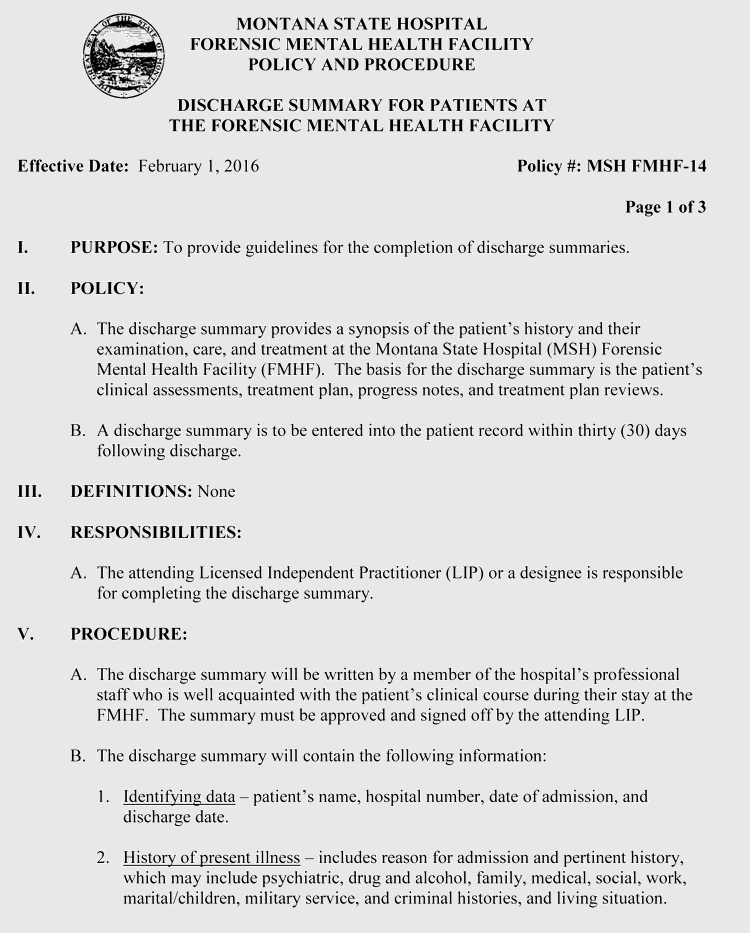

In [ ]:
cv2_imshow(img)

In [ ]:
out_below = pytesseract.image_to_string(img)
out_below=out_below.split('\n')
out_below=' '.join(out_below)

In [103]:
with open('exp.txt', 'w') as writefile:
    writefile.write(out_below)

In [104]:
def read_article(file_name):
    file = open(file_name, "r")
    filedata = file.readlines()
    article = filedata[0].split(". ")
    sentences = []

    for sentence in article:
        #print(sentence)
        sentences.append(sentence.replace("[^a-zA-Z]", " ").split(" "))
    sentences.pop() 
    
    return sentences

In [105]:
def sentence_similarity(sent1, sent2, stopwords=None):
    if stopwords is None:
        stopwords = []
 
    sent1 = [w.lower() for w in sent1]
    sent2 = [w.lower() for w in sent2]
 
    all_words = list(set(sent1 + sent2))
 
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)
 
    # build the vector for the first sentence
    for w in sent1:
        if w in stopwords:
            continue
        vector1[all_words.index(w)] += 1
 
    # build the vector for the second sentence
    for w in sent2:
        if w in stopwords:
            continue
        vector2[all_words.index(w)] += 1
 
    return 1 - cosine_distance(vector1, vector2)

In [106]:
def build_similarity_matrix(sentences, stop_words):
    # Create an empty similarity matrix
    similarity_matrix = np.zeros((len(sentences), len(sentences)))
 
    for idx1 in range(len(sentences)):
        for idx2 in range(len(sentences)):
            if idx1 == idx2: #ignore if both are same sentences
                continue 
            similarity_matrix[idx1][idx2] = sentence_similarity(sentences[idx1], sentences[idx2], stop_words)

    return similarity_matrix

In [129]:
def generate_summary(file_name, top_n=5):
    nltk.download("stopwords")
    stop_words = stopwords.words('english')
    summarize_text = []

    # Step 1 - Read text anc split it
    sentences =  read_article(file_name)

    # Step 2 - Generate Similary Martix across sentences
    sentence_similarity_martix = build_similarity_matrix(sentences, stop_words)

    # Step 3 - Rank sentences in similarity martix
    sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_martix)
    scores = nx.pagerank_numpy(sentence_similarity_graph)

    # Step 4 - Sort the rank and pick top sentences
    ranked_sentence = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)    
    #print("Indexes of top ranked_sentence order are ", ranked_sentence)    

    for i in range(top_n):
      summarize_text.append(" ".join(list(set(ranked_sentence[i][1]))))

    # Step 5 - Offcourse, output the summarize texr
    print("Summarize Text: \n", ". ".join(summarize_text))

In [130]:
generate_summary( "exp.txt", 10)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Summarize Text: 
 contain  will following the discharge 1 The information: summary.  FMHF-14 Effective AT HOSPITAL, 2016 I FORENSIC #: MENTAL 3 THE February PROCEDURE Policy MSH HEALTH PATIENTS Date: STATE POLICY FOR 1, of FACILITY Page SUMMARY DISCHARGE MONTANA 1 AND.  B.  A PROCEDURE:.  2. discharge their at Hospital Forensic a (FMHF) examination, Health the Facility patient’s Montana State treatment The Mental provides of and (MSH) synopsis summary history care,. entered is the (30) days following discharge record thirty patient to A within be into summary. is the patient’s discharge plan, progress and plan treatment assessments, The clinical reviews for summary notes, basis. or Licensed responsible is Independent the discharge Practitioner a designee The summary for attending (LIP) completing. discharge course their at a hospital’s by professional will well the pat